# Donders MML: XDF Preprocessing
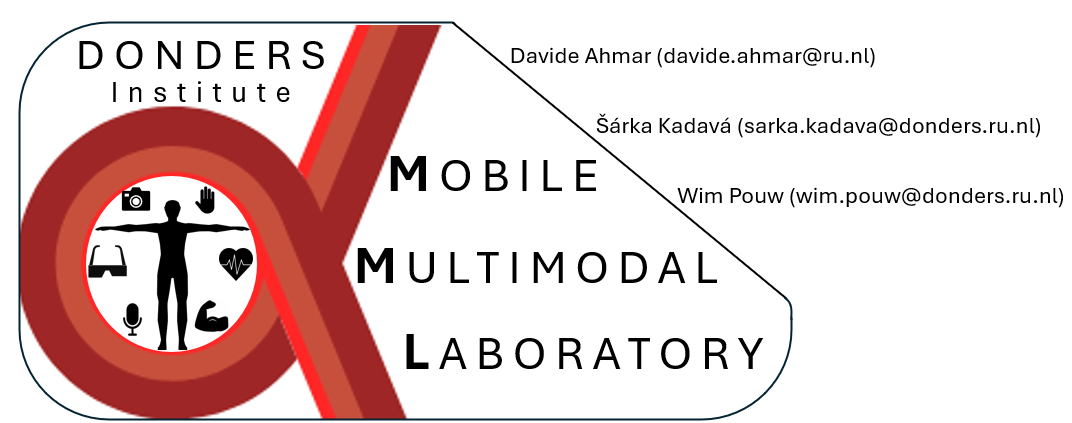

### Info Documents 
Location Repository
Github Repository 
Jupyter Notebook


### Requirements
Please install the necessary packages in requirements.txt using pip install -r requirements.txt


### CODE OVERVIEW
This script is designed to process XDF files, extract data streams, perform renaming and clipping operations, and save the processed data in CSV and WAV formats. The script is structured into several key sections, each performing specific tasks, from importing necessary packages to processing the data and saving the output. Below is a detailed breakdown of each section of the code: 

0. **Packages**
      This section imports all the necessary libraries and modules used throughout the script. These include modules for file handling, data manipulation, audio processing, video processing, plotting, and GUI interaction.
     See requirements.txt for all necessary packages (pip install -r requirements.txt)

1. **Key Variables**
     Users defines the input and output directories for XDF files and result outputs
     - **noise_reducelevel**  Sets the level for noise reduction in audio processing.

    - **extension_to_codec = { ... }**  Maps different file extensions to their corresponding codecs for video processing.
      
    - **rename_dict = { ... }** This dictionary is used to rename certain data streams based on their name and type.
        !! **this dictionary should be adjusted or removed according to the user xdf file**.

1. **Functions**
    - to_audio: Converts time-series data into a WAV audio file.
    - frame_to_time: Converts frame numbers to time format (HH:MM.SS).
    - rename_streams: Renames streams based on the provided dictionary.
    - clip_nonmarker_streams: Clips the start and end of streams based on the shortest stream, excluding marker streams.
    - get_events: Extracts specified events from a marker stream.     

2. **Identifying XDF Files**
   - Method 1. Automatically identifying XDF files in the input directory and its subdirectories by traverses the input directory to find all files with the .xdf extension and adds them to the xdf_files list

    - Method 2.  Manually selecting XDF files using a GUI dialog. Provides an alternative way to manually select XDF files using a graphical file selection dialog.
  
3.  **Identifying XDF Files**

Loading and Renaming Streams: Loads the XDF file and renames streams based on the predefined dictionary.

Clipping Streams: Clips streams to ensure they all start and end at the same time, based on non-marker streams.

Processing Each Stream:

Extracts and formats data from each stream.
Saves the data as CSV files.
Special handling for microphone streams, including saving as WAV files and performing noise reduction.
Subfolder Creation: Automatically creates a subfolder for each XDF file based on its name and saves the processed data inside.
   


## 0. Import all the necessary packages to work with XDF, Audio and Video files 

In [1]:
import os             # Importing the os module which provides functions for interacting with the operating system
import pyxdf          # Importing pyxdf, a Python library for reading XDF files
import glob           # Importing the glob module which helps in finding files/directories with specific patterns
import pandas as pd   # Importing pandas library (abbreviated as pd), which is used for data manipulation and analysis
import numpy as np    # Importing numpy library (abbreviated as np), which is used for numerical computations
import wave           # Importing wave module for reading and writing WAV files (usually audio files) 
import struct         # Importing struct module which provides functions to convert between Python values and C structs
import math           # Importing math module which provides mathematical functions
import random         # Importing random module for generating random numbers
from scipy.io import wavfile  # Importing wavfile module from scipy.io (a library built on numpy), for reading and writing WAV files
import noisereduce as nr      # Importing noisereduce module for noise reduction in audio signals
import json            # Importing json module for working with JSON data
import cv2            # Importing OpenCV library for computer vision tasks
from moviepy.editor import (                # Importing various classes and functions from moviepy.editor module
                            VideoFileClip,  # Class for working with video files
                            AudioFileClip,  # Class for working with audio files
                            CompositeAudioClip)  # Class for composing audio clip
from moviepy.video.io.VideoFileClip import VideoFileClip
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip  # video  clipping fucntion 
from moviepy.video.io.VideoFileClip import VideoFileClip          # alternative video clipping function
import matplotlib.pyplot as plt                                   # Importing pyplot library to create figures and plot data 
from matplotlib.widgets import Slider  
import tkinter                                                    # GUI toolkit to open and save files
from tkinter import filedialog                                    # GUI toolkit to open and save files
import subprocess 

print("Everything was imported succesfully") #as terminal

Everything was imported succesfully


## 1. Define the Relevant Paths, Variables & Functions

In [2]:
# ------------ PATHS -----------------------------------------------------
input_folder = './data_raw/'  # input folder with the raw XDF files (relative path) 
output_folder = './data_processed/'  # output folder where the raw extracted data will be saved (relative path) 

print("Input folder =", os.path.abspath(input_folder))
print("Output folder =", os.path.abspath(output_folder))


# ------------ VARIABLES ----------------------------------------------
noise_reducelevel = 1.5  #This can be changed accordingly 


# Dictionary to map file extensions to codecs
extension_to_codec = {
    '.mp4': 'libx264',
    '.avi': 'libxvid',
    '.mov': 'libx264',
    '.mkv': 'libx264',
    '.flv': 'flv',
    # Add more mappings as needed
                    }


# IF NEEDED: Create a dictionary mapping from old stream names to new stream names (# Edit and add more mappings as needed.) 
     # (This dictionary mapping is based both of the stream_names and stream_types because in our case we have 2 streams with the same name (but different types)) 
rename_dict = {
    ('MyWebcamFrameStream_1', 'frameNR'): 'Video_P1',
    ('MyWebcamFrameStream_2', 'frameNR'): 'Video_P2',
    ('Mic', 'voice'): 'Mic_P1',
    ('Mic_004', 'voice'): 'Mic_P2',
    ('OpenSignals', '00:07:80:8C:06:6A'): 'PLUX_P2',
    ('OpenSignals', '00:07:80:D8:A8:81'): 'PLUX_P1'
}


# -------------FUNCTIONS------------------------------------------------------------------------------------
# AUDIO: Creating a function named "to_audio" tht writes audio data (input) and transforms into a WAV file (output). 
def to_audio(fileloc, timeseries_name, samplerate = 16000, channels = 1):   
    """
    This function - named "to_audio" - writes audio data to a WAV file.
    It accepts the following parameters:
    - fileloc (str): Location to save the audio file.
    - timeseriestype (list): Audio data to be written into the file.
    - samplerate (int, optional): Sampling rate of the audio data. Defaults to 16000.
    - channels (int, optional): Number of audio channels (mono or stereo). Defaults to 1 (mono)
    """
    if 'Mic' in timeseries_name:  #Condition check that the timeseriestype belongs to the microphone.
            
        obj = wave.open(fileloc,'w')        # Opens audio file using the wave.open() function write mode ('w'). Assigns data it to the variable obj.
        obj.setnchannels(channels)          # Sets the number of channels in the audio file using obj.setnchannels(channels). Deafault 1 channel (mono).
        obj.setsampwidth(2)                 # Sets the sample width in bytes using obj.setsampwidth(2). The value '2' indicates 16-bit audio.
        obj.setframerate(float(samplerate)) # sets the frame rate of the audio file using obj.setframerate(float(samplerate)), where samplerate is provided as a parameter.
            
        for i in timeseries:                      # Loop to iterate over each time-point in the temeseries stream
            data = struct.pack('<h', int(i[0]))   # Converts the first value of the timeseries to an integer and packs it into a binary string (struck.pack()) according to the '<h' fromat (i.e., short integer (16 bits) in little-endian byte order)   
            obj.writeframesraw( data )            # Writes the packed binary data into an audio file using the wave function writeframesraw() from the wave library 
        obj.close()                               # Closes the audio file 

print("Function \"to_audio\" created sucesfully") 


# VIDEO: Creating a function named frame_to_time to convert frame number to time format 
def frame_to_time(frame, fps):
    """
    frame_to_time converts a given frame number to a time format (HH:MM:SS.SS) based on the frames per second (fps).
    Arguments:
        frame (int): The frame number to be converted.
        fps (float): The frames per second of the video.
    Returns:
        str: The time format as a string in the format "HH:MM:SS.SS".
    """
    seconds = frame / fps
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = seconds % 60
    return f"{hours:02}:{minutes:02}:{seconds:.2f}"

print("Function \"frame_to_time\" created sucesfully") 



# Renaming XDF Stream (if necessary)
def rename_streams(streams, rename_dict):
    """
    Function rename_stream renames any streams based on the rename dictionary (if name found in remane_dict)
        Parameters:
    stream_name (str): The current name of the stream.
    stream_type (str): The type of the stream.
    rename_dict (dict): A dictionary mapping old stream names and types to new stream names.
        Returns:
    str: The new stream name if found in rename_dict, otherwise the original stream name.
    """
    for stream in streams:
        stream_name = stream['info']['name'][0]
        stream_type = stream['info']['type'][0]

        if (stream_name, stream_type) in rename_dict:
            new_name = rename_dict[(stream_name, stream_type)]
            print(f'Renaming stream {stream_name} ({stream_type}) to {new_name}')
            stream['info']['name'][0] = new_name  # Rename the stream
    return streams

print("Function \"rename_streams\" created sucesfully") 


# Function to clip the streams
def clip_nonmarker_streams(streams):
    """
    Function clip_nonmarker_streams cuts the start and end of all streams that are not "Markers" type in an XDF file based on the shortest stream.
    
    Input: 
        streams: list of streams to be clipped latest_start_time and earliest_end_time of all streams except Markers ones
    Output: 
        clipped streams based on the 
    """
    
    # Filter out marker streams for calculating the latest start and earliest end times
    non_marker_streams = [stream for stream in streams if stream['info']['type'][0] != 'Markers']

    for i in non_marker_streams:
        name_i = i['info']['name'][0]
        print(str(name_i))
    
    # Find the latest start time across all non-marker streams
    begintimes = [stream['time_stamps'][0] for stream in non_marker_streams]
    latest_start_time = max(begintimes)  # Get the first timestamp of each non-marker stream and find the maximum (latest start time)
    print('begin times per stream: ' + str(begintimes))
    print(' latest_start_time' + str(latest_start_time))

    # Find the earliest end time across all non-marker streams
    endtimes = [stream['time_stamps'][-1] for stream in non_marker_streams]
    earliest_end_time = min(endtimes)  # Get the last timestamp of each non-marker stream and find the minimum (earliest end time)
    print('end times per stream: ' + str(endtimes))
    print(' earliest_end_time' + str(earliest_end_time))
    

    clipped_streams = []  # Initialize an empty list to store the clipped streams

    for stream in streams:
        time_stamps = np.array(stream['time_stamps'])  # Convert the timestamps to a NumPy array
        time_series = np.array(stream['time_series'])  # Convert the time series data to a NumPy array

        # Find the index of the closest timestamp to the latest start time
        start_idx = np.searchsorted(time_stamps, latest_start_time, side='left')  # Get the index where the latest start time would fit
        # Ensure the index is within the valid range
        start_idx = max(0, min(start_idx, len(time_stamps) - 1))

        # Find the index of the closest timestamp to the earliest end time
        end_idx = np.searchsorted(time_stamps, earliest_end_time, side='right')  # Get the index where the earliest end time would fit
        # Ensure the index is within the valid range
        end_idx = max(0, min(end_idx, len(time_stamps)))

        print(f"Clipping stream {stream['info']['name'][0]}:")
        print(f" start_idx: {start_idx}, end_idx: {end_idx}")
        print(f" clipped_time_stamps: {time_stamps[start_idx:end_idx]}")

        # Clip the timestamps array to the range between the found indices
        clipped_time_stamps = time_stamps[start_idx:end_idx]  # Select the time stamps within the clipped range
        # Clip the time series data array to the same range
        clipped_time_series = time_series[start_idx:end_idx]  # Select the time series data within the clipped range

        # Create a copy of the original stream dictionary
        clipped_stream = stream.copy()  # Copy the stream dictionary
        # Replace the timestamps and time series data with the clipped versions
        clipped_stream['time_stamps'] = clipped_time_stamps  # Update the timestamps with the clipped data
        clipped_stream['time_series'] = clipped_time_series  # Update the time series with the clipped data

        clipped_streams.append(clipped_stream)  # Add the clipped stream to the list

    return clipped_streams  # Return the list of clipped streams

print("Function \"clip_nonmarker_streams\" created successfully")


# Function to extract specified events (with correspodning LSL times) from XDF stream (useful for plotting)
def get_events(stream, event_names):
    """
    Extracts events and corresponding LSL times from the given stream that match any of the event_names.

    Parameters:
    stream (dict): The stream containing time stamps and event data.
    event_names (list of str): List of event name substrings to look for in the events.

    Returns:
    np.array: An array where each row contains a timestamp and the full event name.
    """
    events = []  # Initialize an empty list to store matching events

    # Check if the stream type is "Markers"
    if stream['info']['type'][0] != "Markers":
        raise ValueError(f"ERROR: The stream provided ({stream['info']['name'][0]}) is not a Marker stream")

    # Iterate over the time stamps and corresponding events in the stream
    for timestamp, event in zip(stream['time_stamps'], stream['time_series']):
        # Check if any of the specified event names are in the current event
        for name in event_names:
            if name in event[0]:
                # If a match is found, append the timestamp and full event name to the list
                events.append([timestamp, event[0]])

    # Convert the list of events to a NumPy array and return it
    return np.array(events)

print("Function \"get_events\" created sucesfully") 


Input folder = c:\Users\ahmar\OneDrive\Documents\GitHub\Mobile-Multimodal-Lab\2_PREPROCESSING\1_XDF_PROCESSING\data_raw
Output folder = c:\Users\ahmar\OneDrive\Documents\GitHub\Mobile-Multimodal-Lab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed
Function "to_audio" created sucesfully
Function "frame_to_time" created sucesfully
Function "rename_streams" created sucesfully
Function "clip_nonmarker_streams" created successfully
Function "get_events" created sucesfully


## 2. Identifying XDF files in Input Folder or any Subfolder 

In [ ]:
xdf_files = []  # Initialize an empty list to store paths of XDF files

# Traverse through the directory and its subdirectories to find XDF files
for root, dirs, files in os.walk(input_folder):  # 1st loop iterating over the results returned by os.walk().
    
    for file in files:                                    # 2nd loop iterating through each file in the current directory
        
        if file.endswith(".xdf"):                         # checking if the file has and XDF extension 
            
             xdf_files.append(os.path.join(root, file))   # if the file is an XDF file, append its full path to the xdf_files list
            
print('We have idenified the following XDF files: ' + str(xdf_files))

## 2a. Alternatively, the user can select their own XDF file

In [3]:
import tkinter # GUI toolkit to open and save files
from tkinter import filedialog # GUI toolkit to open and save files

root = tkinter.Tk()
root.attributes('-topmost',True)
root.iconify()

xdf_files = filedialog.askopenfilename(title="Select an XDF file", filetypes=[("XDF Files", "*.xdf")], multiple = 'True')

root.destroy()

# Convert the tuple returned by askopenfilenames() to a list
xdf_files = list(xdf_files)

print('You have selected the following XDF files: ' + str(xdf_files))

You have selected the following XDF files: ['C:/Users/ahmar/OneDrive/Documents/GitHub/Mobile-Multimodal-Lab/2_PREPROCESSING/1_XDF_PROCESSING/data_raw/T1_experiment.xdf']


# 3. Main Loop that (i) Extracts (ii) Renames and (iii) Clips each data stream from each XDF and saves them as CVS or WAV files 

In [4]:
output_folder = './data_processed/'  # output_folder for the CVS and WAV files 

for xdf_file in xdf_files:               # Iterate over each path in the list "xdf_files". 

    print('loading xdf file: ' + xdf_file )

    streams, header = pyxdf.load_xdf(xdf_file)    # Loading steams and header information from each XDF file usign the load_xdf function from the pyxdf library. 
    fnam = os.path.basename(xdf_file)[:-4]        # Extract the file name from the path and assings it to fnam, whilst removing the '.xdf' extension (i.e., the last 4 characters in the string)
       
    # Renaming streams using the rename_dict and rename_function (if names match dictionary)
    streams = rename_streams(streams, rename_dict)

    # Clipping the streams based on the latest_start_time and earliest_end_time of (any of the) streams in the xdf file. 
    streams = clip_nonmarker_streams(streams)

    # Navigating through each stream and extracting the relevant information (e.g., name, sample rate, data, time, etc.) 
    for stream in streams:                        # Iterate over each steam in the loaded steam for each XDF file .
        timeseries_name = stream['info']['name'][0]                    # Extracts name of each steams (dictionary structure) and assigns it to timeseries_name (e.g., Mic). 
        timeseries_type = stream['info']['type'][0]
        timevec         = stream['time_stamps']                                # Extract the time_stamps (i.e.,LSL TIMESTAMPS) from the "stream" dictionary and assigns it to the variable timevec
        timeseries      = stream['time_series']                              # Extract the time_series (i.e., DATA) from the "stream" dictionary and 
        samplerate      = round(float(stream['info']['nominal_srate'][0]))    # Extracts the rounded sampling rate (nominal_srate) and assings it to samplerate 
        channelcount    = int(stream['info']['channel_count'][0])               # Extracts the number of channel for each steams and assigns it to channelcount (as an integer)

        # Extract channel labels (this step is a bit more complex because of the XDF file configuration)
        channel_labels = []  # Initialize an empty list to store channel labels
        
        # Check if there is more than one channel and if the 'desc' field is present in the stream's info
        if channelcount > 1 and stream['info']['desc'] is not None:
            try:
                channels_info = stream['info']['desc'][0]['channels'][0]['channel']  # Attempt to extract channel information from the stream's description
                channel_labels = [channel['label'][0] for channel in channels_info]  # Create a list of channel labels by extracting the 'label' field from each channel's info
            except (KeyError, IndexError):
                channel_labels = [f"Channel {i+1}" for i in range(channelcount)]  # If there is any issue with extracting channel labels, create default labels
        else:
            channel_labels = [f"Channel {i+1}" for i in range(channelcount)]  # If there is only one channel or the 'desc' field is not present, create default labels
        
        print('working on stream: ' + timeseries_name + '  with a channel count of: ' + str(channelcount) + ' labelled: ' + str(channel_labels) + ' and a sampling rate of ' + str(samplerate))        

        # Saving each stream of the XDF file as a CSV (if it doesn't exist yet) 
        matrix_aux = np.vstack([np.transpose(timevec),np.transpose(timeseries)])   # Create matrix_aux by concatenating the transposed timevec and timeseries
        matrix     = np.transpose(matrix_aux)                                      # Create new matrix by tranposing matrix_aux
        column_names = ["LSL_Time"] + [f"{timeseries_name}_{label}" for label in channel_labels]  # Create column names for the matrix. The first column is named "LSL_Time" (i.e., timevec), The subsequent columns are named using the format {timeseries_name}_{label} for each channel label. 
        df_lab = pd.DataFrame(matrix, columns = column_names)                                     # Create a DataFrame df_lab with the combined data and the appropriate column names.

        print('start time: ' + str(min(timevec)))
        print('end time: ' + str(max(timevec)))
        
        # Saving 
        subfolder_path = os.path.join(output_folder, fnam.split('_')[0])    # Create the subfolder path
        os.makedirs(subfolder_path, exist_ok=True)                         # Create the subfolder if it doesn't exist
        print('Saving: ' + fnam + '_' + timeseries_name + " in folder " + subfolder_path) 
        df_lab.to_csv(os.path.join(subfolder_path, f'{fnam}_{timeseries_name}.csv'), index=False)
      

        if "Mic" in timeseries_name:  # Check if the data stream is from a microphone
            wavloc = os.path.abspath(subfolder_path + fnam + '_' + timeseries_name  + '.wav')  # Define the location to save the initial audio file
            to_audio(wavloc, timeseries_name)  # Convert the time series data to an audio file and save it at the defined location
            rate, data = wavfile.read(wavloc)  # Load the audio data from the saved WAV file
            reduced_noise = nr.reduce_noise(y=data, sr=rate, n_std_thresh_stationary=noise_reducelevel, stationary=True)    # Perform noise reduction based on the noise_reducelevel 
            wavloc2 = os.path.abspath(subfolder_path + fnam + '_' + timeseries_name + '_denoised.wav')  # Define the location to save the noise-reduced audio file
            wavfile.write(wavloc2, rate, reduced_noise)  # Save the noise-reduced audio data as a new WAV file at the defined location

print("Done with extracting all the streams! You can now look into your folder: " + output_folder)

loading xdf file: C:/Users/ahmar/OneDrive/Documents/GitHub/Mobile-Multimodal-Lab/2_PREPROCESSING/1_XDF_PROCESSING/data_raw/T1_experiment.xdf
Renaming stream MyWebcamFrameStream_2 (frameNR) to Video_P2
Renaming stream MyWebcamFrameStream_1 (frameNR) to Video_P1
Renaming stream OpenSignals (00:07:80:8C:06:6A) to PLUX_P2
Renaming stream OpenSignals (00:07:80:D8:A8:81) to PLUX_P1
Renaming stream Mic (voice) to Mic_P1
Renaming stream Mic_004 (voice) to Mic_P2
Video_P2
Video_P1
PLUX_P2
PLUX_P1
Mic_P1
Mic_P2
begin times per stream: [6340.566187627697, 6340.957448231628, 6341.679350981375, 6341.68292020151, 6341.760356983359, 6341.837644506075]
 latest_start_time6341.837644506075
end times per stream: [7330.334929689852, 7328.912870295735, 7330.700726246735, 7330.704584839515, 7330.838791492886, 7330.845650206361]
 earliest_end_time7328.912870295735
Clipping stream AudioEvents:
 start_idx: 0, end_idx: 100
 clipped_time_stamps: [6366.91126373 6370.37102452 6377.58866336 6384.8060832  6397.01303

## 4. Plotting Each XDF and Each Stream (Quality Check)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

event_names = ['_StartParticipantSinging', '_EndParticipantSinging']


# Navigating through each stream and extracting the relevant information (e.g., name, sample rate, data, time, etc.)
for stream in streams:  # Iterate over each steam in the loaded steam for each XDF file.
    timeseries_name = stream['info']['name'][0]  # Extracts name of each steams (dictionary structure) and assigns it to timeseries_name (e.g., Mic).
    timeseries_type = stream['info']['type'][0]  # Extracts type of each steams (dictionary structure) and assigns it to timeseries_type (e.g., Markers).
    timevec = stream['time_stamps']  # Extract the time_stamps (i.e.,LSL TIMESTAMPS) from the "stream" dictionary and assigns it to the variable timevec
    timeseries = stream['time_series']  # Extract the time_series (i.e., DATA) from the "stream" dictionary and
    samplerate = round(float(stream['info']['nominal_srate'][0]))  # Extracts the rounded sampling rate (nominal_srate) and assigns it to samplerate
    channelcount = int(stream['info']['channel_count'][0])  # Extracts the number of channel for each steams and assigns it to channelcount (as an integer)

    # Extract channel labels (this step is a bit more complex because of the XDF file configuration)
    channel_labels = []  # Initialize an empty list to store channel labels
    # Check if there is more than one channel and if the 'desc' field is present in the stream's info
    if channelcount > 1 and stream['info']['desc'] is not None:
        try:
            channels_info = stream['info']['desc'][0]['channels'][0]['channel']  # Attempt to extract channel information from the stream's description
            channel_labels = [channel['label'][0] for channel in channels_info]  # Create a list of channel labels by extracting the 'label' field from each channel's info
        except (KeyError, IndexError):
            channel_labels = [f"Channel {i + 1}" for i in range(channelcount)]  # If there is any issue with extracting channel labels, create default labels
    else:
        channel_labels = [f"Channel {i + 1}" for i in range(channelcount)]  # If there is only one channel or the 'desc' field is not present, create default labels

    print('working on stream: ' + timeseries_name + '  with a channel count of: ' + str(channelcount) + ' labelled: ' + str(channel_labels) + ' and a sampling rate of ' + str(samplerate))

    # Extracting Relevant Events from Marker Stream that will be used as Selectors in the Plots
    if timeseries_type == 'Markers':
        audio_events = get_events(stream, event_names)  # Using the get_events function to extract events and corresponding LSL times from Marker stream

        # Create selector buttons based on audio events
        selector_buttons = []
        for i in range(0, len(audio_events), 2):
            start_event = audio_events[i]
            end_event = audio_events[i + 1]
            condition_name = start_event[1].split('_StartParticipantSinging')[0]
            selector_buttons.append(dict(label=condition_name,
                                         method="relayout",
                                         args=[{"xaxis.range": [float(start_event[0]), float(end_event[0])]}]))

        continue  # Skips plotting for Markers stream

    # PLOTTING
    timeseries = np.array(timeseries)  # Ensure timeseries is a NumPy array

    # Plotting subplots in case of multiple channels
    if channelcount > 1:
        fig = make_subplots(rows=channelcount, cols=1, shared_xaxes=True, vertical_spacing=0.02, subplot_titles=channel_labels)

        for i in range(channelcount):
            fig.add_trace(go.Scatter(
                x=timevec,
                y=timeseries[:, i],
                mode='lines',
                name=channel_labels[i]
            ), row=i + 1, col=1)

        # Update x-axis settings for the last subplot
        fig.update_xaxes(
            rangeslider=dict(visible=True),
            type="linear",
            row=channelcount, col=1
        )
        
        fig.update_layout(
            title_text=fnam + '_' + timeseries_name + ' Streams',
            height=150 * channelcount + 150,
            yaxis_title='Amplitude',
            updatemenus=[dict(type="buttons", buttons=selector_buttons, direction="down", showactive=True)]
        )
        fig.show()

    else:
        # Plotting single channel data stream
        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=timevec,
            y=timeseries[:, 0],
            mode='lines',
            name=channel_labels[0]
        ))

        fig.update_layout(
            title_text=fnam + '_' + timeseries_name + ' Streams',
            xaxis=dict(
                rangeselector=dict(buttons=selector_buttons),
                rangeslider=dict(visible=True),
                type="linear"
            ),
            yaxis_title='Amplitude',
            updatemenus=[dict(type="buttons", buttons=selector_buttons, direction="down", showactive=True)]
        )

        fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

event_names = ['_StartParticipantSinging', '_EndParticipantSinging']


for xdf_file in xdf_files:               # Iterate over each path in the list "xdf_files". 

    print('loading xdf file: ' + xdf_file )

    streams, header = pyxdf.load_xdf(xdf_file)    # Loading steams and header information from each XDF file usign the load_xdf function from the pyxdf library. 
    fnam = os.path.basename(xdf_file)[:-4]        # Extract the file name from the path and assings it to fnam, whilst removing the '.xdf' extension (i.e., the last 4 characters in the string)
       
    # Renaming streams using the rename_dict and rename_function (if names match dictionary)
    streams = rename_streams(streams, rename_dict)

    # Navigating through each stream and extracting the relevant information (e.g., name, sample rate, data, time, etc.) 
    for stream in streams:                        # Iterate over each steam in the loaded steam for each XDF file .
        timeseries_name = stream['info']['name'][0]                    # Extracts name of each steams (dictionary structure) and assigns it to timeseries_name (e.g., Mic). 
        timeseries_type = stream['info']['type'][0]                     # Extracts type of each steams (dictionary structure) and assigns it to timeseries_type (e.g., Markers). 
        timevec = stream['time_stamps']                                # Extract the time_stamps (i.e.,LSL TIMESTAMPS) from the "stream" dictionary and assigns it to the variable timevec
        timeseries = stream['time_series']                             # Extract the time_series (i.e., DATA) from the "stream" dictionary and 
        samplerate = round(float(stream['info']['nominal_srate'][0]))  # Extracts the rounded sampling rate (nominal_srate) and assings it to samplerate 
        channelcount = int(stream['info']['channel_count'][0])         # Extracts the number of channel for each steams and assigns it to channelcount (as an integer)

        # Extract channel labels (this step is a bit more complex because of the XDF file configuration)
        channel_labels = []  # Initialize an empty list to store channel labels
        # Check if there is more than one channel and if the 'desc' field is present in the stream's info
        if channelcount > 1 and stream['info']['desc'] is not None:
            try:
                channels_info = stream['info']['desc'][0]['channels'][0]['channel']  # Attempt to extract channel information from the stream's description
                channel_labels = [channel['label'][0] for channel in channels_info]  # Create a list of channel labels by extracting the 'label' field from each channel's info
            except (KeyError, IndexError):
                channel_labels = [f"Channel {i+1}" for i in range(channelcount)]  # If there is any issue with extracting channel labels, create default labels
        else:
            channel_labels = [f"Channel {i+1}" for i in range(channelcount)]  # If there is only one channel or the 'desc' field is not present, create default labels

        
        print('working on stream: ' + timeseries_name + '  with a channel count of: ' + str(channelcount) + ' labelled: ' + str(channel_labels) + ' and a sampling rate of ' + str(samplerate)) 
        
        
        
        # Extracting Relevant Events from Marker Steam that will be used as Selectors in the Plots 
        if timeseries_type == 'Markers':
            audio_events = get_events(stream, event_names)  #Using the get_events function to extracts events and corresponding LSL times from Marker stream

             # Create selector buttons based on audio events
            selector_buttons = []
            for i in range(0, len(audio_events), 2):
                start_event = audio_events[i]
                end_event = audio_events[i + 1]
                condition_name = start_event[1].split('_StartParticipantSinging')[0]
                selector_buttons.append(dict(label=condition_name,
                                             method="relayout",
                                             args=[{"xaxis.range": [float(start_event[0]), float(end_event[0])]}]))
                        
            continue    # Skips plotting for Markers stream 
            
        # PLOTTING 
        timeseries = np.array(timeseries)   # Ensure timeseries is a NumPy array
        
         # Plotting subplots in case of multiple channels
        if channelcount > 1:
            fig = make_subplots(rows=channelcount, cols=1, shared_xaxes=True, vertical_spacing=0.02, subplot_titles=channel_labels)
        
            for i in range(channelcount):
                fig.add_trace(go.Scatter(
                    x=timevec, 
                    y=timeseries[:, i],
                    mode='lines',
                    name=channel_labels[i]
                ), row=i+1, col=1)
        
            # Update x-axis settings for the last subplot
            fig.update_xaxes(
                rangeslider=dict(visible=True),
                type="linear",
                row=channelcount, col=1
            )

            fig.update_layout(
                title_text=fnam + '_' + timeseries_name + ' Streams',
                height=150 * channelcount + 150,
                yaxis_title='Amplitude',
                updatemenus=[dict(buttons=selector_buttons, direction="down", showactive=True)]
            )

            fig.show()
            
        else:
            # Plotting single channel data stream
            fig = go.Figure()

            fig.add_trace(go.Scatter(
                x=timevec,
                y=timeseries[:, 0],
                mode='lines',
                name=channel_labels[0]
            ))

            fig.update_layout(
                title_text=fnam + '_' + timeseries_name + ' Streams',
                xaxis=dict(
                    rangeselector=dict(buttons=selector_buttons),
                    rangeslider=dict(visible=True),
                    type="linear"
                ),
                yaxis_title='Amplitude',
                updatemenus=[dict(buttons=selector_buttons, direction="down", showactive=True)]
            )

            fig.show()

In [ ]:
print(selector_buttons)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

event_names = ['_StartParticipantSinging', '_EndParticipantSinging']


for xdf_file in xdf_files:               # Iterate over each path in the list "xdf_files". 

    print('loading xdf file: ' + xdf_file )

    streams, header = pyxdf.load_xdf(xdf_file)    # Loading steams and header information from each XDF file usign the load_xdf function from the pyxdf library. 
    fnam = os.path.basename(xdf_file)[:-4]        # Extract the file name from the path and assings it to fnam, whilst removing the '.xdf' extension (i.e., the last 4 characters in the string)
       
    # Renaming streams using the rename_dict and rename_function (if names match dictionary)
    streams = rename_streams(streams, rename_dict)

    # Navigating through each stream and extracting the relevant information (e.g., name, sample rate, data, time, etc.) 
    for stream in streams:                        # Iterate over each steam in the loaded steam for each XDF file .
        timeseries_name = stream['info']['name'][0]                    # Extracts name of each steams (dictionary structure) and assigns it to timeseries_name (e.g., Mic). 
        timeseries_type = stream['info']['type'][0]                     # Extracts type of each steams (dictionary structure) and assigns it to timeseries_type (e.g., Markers). 
        timevec = stream['time_stamps']                                # Extract the time_stamps (i.e.,LSL TIMESTAMPS) from the "stream" dictionary and assigns it to the variable timevec
        timeseries = stream['time_series']                             # Extract the time_series (i.e., DATA) from the "stream" dictionary and 
        samplerate = round(float(stream['info']['nominal_srate'][0]))  # Extracts the rounded sampling rate (nominal_srate) and assings it to samplerate 
        channelcount = int(stream['info']['channel_count'][0])         # Extracts the number of channel for each steams and assigns it to channelcount (as an integer)

        # Extract channel labels (this step is a bit more complex because of the XDF file configuration)
        channel_labels = []  # Initialize an empty list to store channel labels
        # Check if there is more than one channel and if the 'desc' field is present in the stream's info
        if channelcount > 1 and stream['info']['desc'] is not None:
            try:
                channels_info = stream['info']['desc'][0]['channels'][0]['channel']  # Attempt to extract channel information from the stream's description
                channel_labels = [channel['label'][0] for channel in channels_info]  # Create a list of channel labels by extracting the 'label' field from each channel's info
            except (KeyError, IndexError):
                channel_labels = [f"Channel {i+1}" for i in range(channelcount)]  # If there is any issue with extracting channel labels, create default labels
        else:
            channel_labels = [f"Channel {i+1}" for i in range(channelcount)]  # If there is only one channel or the 'desc' field is not present, create default labels

        
        print('working on stream: ' + timeseries_name + '  with a channel count of: ' + str(channelcount) + ' labelled: ' + str(channel_labels) + ' and a sampling rate of ' + str(samplerate)) 
        
        
        
        # Extracting Relevant Events from Marker Steam that will be used as Selectors in the Plots 
        if timeseries_type == 'Markers':
            audio_events_steam = get_events(stream, event_names)  #Using the get_events function to extracts events and corresponding LSL times from Marker stream

            continue    # Skips plotting for Markers stream 
            
        # PLOTTING 
        timeseries = np.array(timeseries)   # Ensure timeseries is a NumPy array
        
        # Plotting subplots in case of multiple streams 
        if channelcount > 1:
            fig = make_subplots(rows=channelcount, cols=1, shared_xaxes=True, vertical_spacing=0.02, subplot_titles=channel_labels)
        
            for i in range(channelcount):
                fig.add_trace(go.Scatter(
                    x=timevec, 
                    y=timeseries[:, i],
                    mode='lines',
                    name=channel_labels[i]
                ), row=i+1, col=1)
        
                fig.update_yaxes(title_text=channel_labels[i], row=i+1, col=1)
        
            # Update x-axis settings for all subplots
            fig.update_layout(
                title_text=fnam + '_' + timeseries_name + ' Streams',
                height=300 * channelcount,
                xaxis=dict(
                    rangeselector=dict(
                        buttons=list([
                            dict(count=1,
                                 label="1m",
                                 step="minute",
                                 stepmode="backward"),
                            dict(count=10,
                                 label="10m",
                                 step="minute",
                                 stepmode="backward"),
                            dict(step="all")
                        ])
                    ),
                    rangeslider=dict(
                        visible=True
                    ),
                    type="linear"
                ),
                yaxis_title='Amplitude'
            )
        
            fig.show()
                    
        else:
            # Plotting single channel data stream
            fig = go.Figure()
            timeseries = np.array(timeseries)  # Ensure timeseries is a NumPy array
        
            fig.add_trace(go.Scatter(
                x=timevec,
                y=timeseries[:, 0],
                mode='lines',
                name=channel_labels[0]
            ))
        
            fig.update_layout(
                title_text=fnam + '_' + timeseries_name + ' Streams',
                xaxis=dict(
                    rangeselector=dict(
                        buttons=list([
                            dict(count=1,
                                 label="1m",
                                 step="minute",
                                 stepmode="backward"),
                            dict(count=10,
                                 label="10m",
                                 step="minute",
                                 stepmode="backward"),
                            dict(step="all")
                        ])
                    ),
                    rangeslider=dict(
                        visible=True
                    ),
                    type="linear"
                ),
                yaxis_title='Amplitude'
            )
        
            fig.show()

                

In [ ]:
                     # fig.show()
        
            #     # Update x-axis settings for the last subplot
            #     if i == channelcount-1:
            #         fig.update_xaxes(
            #             rangeselector=dict(
            #                 buttons=list([
            #                     dict(count=1,
            #                          label="1m",
            #                          step="minute",
            #                          stepmode="backward"),
            #                     dict(count=10,
            #                          label="10m",
            #                          step="minute",
            #                          stepmode="backward"),
            #                     dict(step="all")
            #                 ])
            #             ),
            #             rangeslider=dict(
            #                 visible=True
            #             ),
            #             type="linear",
            #             row=i+1, col=1
                        )

            # Plotting Events (i.e., triggers) 
        # if stream['info']['channel_format'][0] == 'string':
        #     plt.figure(figsize=(12, 6))
        #     y_pos = np.arange(len(timevec))  # Create a y-position for each event to avoid overlap
        #     plt.scatter(timevec, [1] * len(timevec), marker='o')
        #     for i, event in enumerate(timeseries):
        #         plt.text(timevec[i], 1.01, event[0], rotation=45, ha='right', va='bottom', fontsize=6)
        #     plt.title(fnam + '_' + timeseries_type + ' Events')
        #     plt.xlabel('Time')
        #     plt.yticks([])
        #     plt.grid(True)
        #     plt.show()


        #     else:
        #     # Plotting data streams with Plotly subplots if multiple channels
        



            
            # # Plotting data streams with subplots and sliders
            # fig, axs = plt.subplots(channelcount, 1, figsize=(12, 6 * channelcount), sharex=True)
            # timeseries = np.array(timeseries)
            # if channelcount == 1:
            #     axs = [axs]  # Ensure axs is always a list

            # for i in range(channelcount):
            #     axs[i].plot(timevec, timeseries[:, i], label=channel_labels[i])
            #     axs[i].set_title(f'{channel_labels[i]}')
            #     axs[i].set_ylabel('Amplitude')
            #     axs[i].grid(True)
            #     axs[i].legend()

            # axs[-1].set_xlabel('Time')

            # # Adding slider for each subplot
            # sliders = []
            # axcolor = 'lightgoldenrodyellow'
            # for i in range(channelcount):
            #     ax_slider = plt.axes([0.25, 0.02 + i * 0.04, 0.65, 0.03], facecolor=axcolor)
            #     slider = Slider(ax_slider, 'Range', timevec[0], timevec[-1], valinit=timevec[-1])
            #     sliders.append(slider)

            #     def update(val, ax=axs[i], slider=slider):
            #         pos = slider.val
            #         ax.set_xlim(timevec[0], pos)
            #         fig.canvas.draw_idle()

            #     slider.on_changed(update)

            # plt.tight_layout()
            # plt.show()
             
        # else:
        #         # Plotting data streams 
        #     plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
        #     timeseries = np.array(timeseries)
        #     for i in range(channelcount):
        #         plt.plot(timevec, timeseries[:, i], label=channel_labels[i])
        #     plt.title(fnam + '_' + timeseries_type + ' Streams')
        #     plt.xlabel('Time')
        #     plt.ylabel('Amplitude')
        #     plt.legend()
        #     plt.grid(True)
        #     plt.show()
        ## -------------------------------------------------

Add a plotting/quality check passage to see each stream and each channel 

For Opensignals, maybe add subpanels to change the y axis. 
    subplots with total height of bigger plot. 

    Envision box plotly (selecting, smoothing and deriving measures) --> Use the slider range as well 

Naming the files. 
    In the lab setup, we will publish the scripts that stream the data to Lab recorder. 
    Each stream should be named accordingly 
    For now, we can change the actual stream names in the xdf file manually by using pyXDF (the same names will be used). 

Creating saving xdf folders for each session. Name of files will be Session_X_P_X_streamname



Downsampling the videos 

go into timevec (original fps is about 200 with LSL)
indent every 1/5 and extract the timevec (LSL time) and timeseries data 
Put into a new matrix
Go into the video with this new matrix and 

## 4. Clipping videos 

In [11]:
# from tqdm import tqdm
from tqdm.notebook import tqdm

input_video_folder = './video_raw/'    # this folder should only contain the videos you want to process. 
output_video_folder = './video_cut/'
input_file_folder = './data_processed/'

# List of participant file pairs
participants_files = [
    ('Video_P1', 'P1'),
    ('Video_P2', 'P2')
]

# Loading the relevant CSV files (called here ') that contain the LSL_time stamps and corresponding video frames
for participant_frame, participant_video in participants_files:
    
    # Loading the relevant CSV files for each participant
    for file in os.listdir(os.path.abspath(input_file_folder)):
        
        if participant_frame in file:  # Check for the corresponding participant
            
            print(f'Processing {participant_frame} for {participant_video}: {file}')
            
            file_path = os.path.join(os.path.abspath(input_file_folder), file)
            print(f'This is the file path: {file_path}')

            print('loading the csv file  ' + str(file) + 'containing LSL times and frames numbers  ' ) 

            # Loading the CSV file
            file_data = pd.read_csv(file_path) # Reads the CSV file at the constructed path into a DataFrame called file_data 

           
           #-----------  Downsampling----------------
            print('Downsampling the LSL times and frame numbers to 50fps. This might take some time')
        
            downsampled_data = file_data.copy()    #creating a copy to work with. 
           
            # Resample to 50 fps (every 20ms)
            resampled_time = np.arange(downsampled_data.iloc[:, 0].min(), downsampled_data.iloc[:, 0].max(), 1/50)

            # Initialize the progress bar
            pbar = tqdm(total=len(resampled_time), desc="Downsampling LSL times and frames")

            #Looping over the LSL_times to find the closest time and frame index 
            resampled_frames = []
            for time in resampled_time:
                closest_index = (downsampled_data.iloc[:, 0] - time).abs().idxmin()
                resampled_frames.append(downsampled_data.iloc[closest_index, 1])
                pbar.update(1)  # Update the progress bar

             # Convert resampled frames to a DataFrame  (useful for further processing)
            resampled_data = pd.DataFrame({
                'LSL_time': resampled_time,
                'Video_Frames': resampled_frames
            })

            print("length of original video LSL csv: " + len(file_data))
            print("length of resampled video LSL csv: " + len(resampled_data))

            print("min value resampled: " + resampled_data.iloc[:, 1].min())
            print("max value resampled" + resampled_data.iloc[:, 1].max())

            print("2 nd value resampled: " + resampled_data.iloc[:, 1].min())
            print("end to last value resampled" + resampled_data.iloc[:, 1].max())         


            # Loading the original videos corresponding to the CSV files that will be cut according to resampled_data
            for video in os.listdir(os.path.abspath(input_video_folder)):
                
                if participant_video in video:  # Check for the corresponding participant  
                    
                    print('Now loading video: ' + video)
                    
                    video_filepath = os.path.join(os.path.abspath(input_video_folder), video)
                    capture = cv2.VideoCapture(video_filepath)  
                
                    # Extracting relevant meta-data about the video using CV2
                    print('Now extracting metadata from video: ' + video)
                    
                    video_frame_width  = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))  
                    video_frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))  
                    video_frame_rate   = capture.get(cv2.CAP_PROP_FPS)
                    video_tot_frames   = int(capture.get(cv2.CAP_PROP_FRAME_COUNT)) 
                    
                    print('video_tot_frames: ' +  str(video_tot_frames))
                    print('Video frames per second: ' + str(video_frame_rate))
            
            
                     # ------------  Downsampling Videos -----------------
                    print('Now re-writing the video ' + video + ' based on the donwsampled LSL times and frames')
            
                    # Prepare to write the new video
                    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Specify the codec for the AVI format. 'XVID' is commonly used for AVI files.
                    output_filepath = os.path.join(output_video_folder, f'cut_{participant_video}.avi')  # Set the path for the output video file with an AVI extension.
                    out = cv2.VideoWriter(output_filepath, fourcc, 50, (video_frame_width, video_frame_height))  # Initialize the VideoWriter object to write frames to a new video file.

                    # Read and write the resampled frames
                    frame_count = 0  # Initialize a counter for the current frame being processed
                    with tqdm(total=video_tot_frames, desc="Rewriting Video Progress", leave=False, ncols=100) as pbar:
                        while capture.isOpened():
                            # Read the next frame
                            ret, frame = capture.read()
                            if ret:
                                # Increment the frame count
                                frame_count += 1 
                                pbar.update(1)  # Update the progress bar
                                
                                if frame_count in resampled_frames:
                                    #cv2.imshow('frame',frame)
                                    #cv2.waitKey(1000/30)
                                    out.write(frame)
                                pbar.update(1)  # Update the progress bar
                            else:
                                break
            
                    
                    capture.release()
                    out.release()
                    
                    print(f'Video saved as {output_filepath}')
            
print("Done with cutting all videos! You can now look into your folder: " + output_video_folder)

Processing Video_P1 for P1: T1_experiment_Video_P1.csv
This is the file path: C:\Users\ahmar\OneDrive\Documents\GitHub\Mobile-Multimodal-Lab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed\T1_experiment_Video_P1.csv
loading the csv file  T1_experiment_Video_P1.csvcontaining LSL times and frames numbers  
Downsampling the LSL times and frame numbers to 50fps. This might take some time


Downsampling LSL times and frames:   0%|          | 0/49354 [00:00<?, ?it/s]

TypeError: can only concatenate str (not "int") to str

In [ ]:
# Extracting relevant information from this CSV file 
LSL_begin_time = resampled_data.iloc[:,0].min()       # Extracts the minimum value from the first column in the resampled_data (i.e., the first LSL_timestamps). 
LSL_begin_frame = int(resampled_data.iloc[:,1].min())  # Extracts the minimum value from the second column in the resampled_data (i.e., the first video frame)
LSL_end_time = resampled_data.iloc[:,0].max()          # Extracts the maximum value from the first column in the resampled_data (i.e., the last LSL_timestamps).
LSL_end_frame = int(resampled_data.iloc[:,1].max())    # Extracts the maximum value from the second column in the file_data (i.e., the last video frame).

LSL_tot_frames = LSL_end_frame - LSL_begin_frame    # Total number of frames from start to finish recording.
LSL_frames = range(LSL_begin_frame, LSL_end_frame)  # Sequence of all frames numbered from the start to the end. 

LSL_fps = round((LSL_tot_frames / (LSL_end_time - LSL_begin_time)), 3)

print(len(resampled_time))
print(len(file_data))

print(LSL_begin_time)
print(LSL_begin_frame)
print(LSL_end_frame)
print(LSL_end_frame)
print(LSL_fps)

print(resampled_time)
# print(resampled_frames)

In [ ]:
from tqdm import tqdm

input_video_folder = './video_raw/'    # this folder should only contain the videos you want to process. 
output_video_folder = './video_cut_2/'
input_file_folder = './data_processed/'

# List of participant file pairs
participants_files = [
    ('Video_P1', 'P1'),
    ('Video_P2', 'P2')
]


# Loading the original videos corresponding to the CSV files that will be cut according to resampled_data
for video in os.listdir(os.path.abspath(input_video_folder)):
    
    if participant_video in video:  # Check for the corresponding participant  
        
        print('Now loading video: ' + video)
        
        video_filepath = os.path.join(os.path.abspath(input_video_folder), video)
        capture = cv2.VideoCapture(video_filepath)  
    
        # Extracting relevant meta-data about the video using CV2
        print('Now extracting metadata from video: ' + video)
        
        video_frame_width  = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))  
        video_frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))  
        video_frame_rate   = capture.get(cv2.CAP_PROP_FPS)
        video_tot_frames   = int(capture.get(cv2.CAP_PROP_FRAME_COUNT)) 
        
        print('video_tot_frames: ' +  str(video_tot_frames))
        print('Video frames per second: ' + str(video_frame_rate))


         # ------------  Downsampling Videos -----------------
        print('Now re-writing the video ' + video + ' based on the donwsampled LSL times and frames')

        # Prepare to write the new video
        fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Specify the codec for the AVI format. 'XVID' is commonly used for AVI files.
        output_filepath = os.path.join(output_video_folder, f'cut_{participant_video}.avi')  # Set the path for the output video file with an AVI extension.
        out = cv2.VideoWriter(output_filepath, fourcc, 50, (video_frame_width, video_frame_height))  # Initialize the VideoWriter object to write frames to a new video file.
        
        # Read and write the resampled frames
        frame_count = 0  # Initialize a counter for the current frame being processed.
        with tqdm(total=video_tot_frames, desc="Processing Video Frames") as pbar:
            while capture.isOpened():
                # Read the next frame
                ret, frame = capture.read()
                if ret:
                    # Increment the frame count
                    frame_count += 1 
                    if frame_count in resampled_frames:
                        #cv2.imshow('frame',frame)
                        #cv2.waitKey(1000/30)
                        out.write(frame)
                    pbar.update(1)  # Update the progress bar
                else:
                    break

        
        capture.release()
        out.release()
        print(f'Video saved as {output_filepath}')

print("Done with cutting all videos! You can now look into your folder: " + output_video_folder)





            
        #     if frame_count > video_tot_frames:
        #         capture.release()
        #         out.release() 
        
        # capture.release()
        # out.release()
        # print(f'Video saved as {output_filepath}')

        # # Prepare to write the new video
        # fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Specify the codec for the AVI format. 'XVID' is commonly used for AVI files.
        # output_filepath = os.path.join(output_video_folder, f'cut_{participant_video}.avi')  # Set the path for the output video file with an AVI extension.
        # out = cv2.VideoWriter(output_filepath, fourcc, 50, (video_frame_width, video_frame_height))  # Initialize the VideoWriter object to write frames to a new video file.
        
        # # Read and write the resampled frames
        # current_frame = 0  # Initialize a counter for the current frame being processed.
        # for frame_idx in resampled_frames:  # Loop through each frame index in the resampled frames list.
        #     capture.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)  # Set the video capture to the position of the desired frame index.
        #     ret, frame = capture.read()  # Read the frame at the current position.
        #     if not ret:  # If the frame is not read correctly (e.g., end of the video), break the loop.
        #         print(f'Frame at index {frame_idx} could not be read.')
        #         break
        #     out.write(frame)  # Write the read frame to the new video file.
        #     current_frame += 1  # Increment the frame counter.          

        #  while capture.isOpened():
        #                 # Read the next frame
        #     ret, frame = capture.read()
        #     if ret:
        #          # Increment the frame count
        #         frame_count += 1 
        #         if frame_count in resampled_frames:
        #             #cv2.imshow('frame',frame)
        #             #cv2.waitKey(1000/30)
        #             out.write(frame)
        #     if frame > video_tot_frames:
        #         capture.release()
        #         out.release() 
        
        # capture.release()
        # out.release()
        # print(f'Video saved as {output_filepath}')


In [ ]:
             # Loading the original videos corresponding to the CSV files that will be cut according to resampled_data
            for video in os.listdir(os.path.abspath(input_video_folder)):
                
                if participant_video in video:  # Check for the corresponding participant  
                    
                    print('Now loading video: ' + video)
                    
                    video_filepath = os.path.join(os.path.abspath(input_video_folder), video)
                    capture = cv2.VideoCapture(video_filepath)  
                
                    # Extracting relevant meta-data about the video using CV2
                    print('Now extracting metadata from video: ' + video)
                    
                    video_frame_width  = capture.get(cv2.CAP_PROP_FRAME_WIDTH)  
                    video_frame_height = capture.get(cv2.CAP_PROP_FRAME_HEIGHT)  
                    video_frame_rate   = capture.get(cv2.CAP_PROP_FPS)
                    video_tot_frames   = int(capture.get(cv2.CAP_PROP_FRAME_COUNT)) 
                    capture.release()
                    print('video_tot_frames: ' +  str(video_tot_frames))
                    print('Video frames per second: ' + str(video_frame_rate))


                     # ------------  Downsampling Videos -----------------
                    print('Now re-writing the video ' + video + ' based on the donwsampled LSL times and frames')

                    # Prepare to write the new video
                    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Specify the codec for the AVI format. 'XVID' is commonly used for AVI files.
                    output_filepath = os.path.join(output_video_folder, f'cut_{participant_video}.avi')  # Set the path for the output video file with an AVI extension.
                    out = cv2.VideoWriter(output_filepath, fourcc, 50, (video_frame_width, video_frame_height))  # Initialize the VideoWriter object to write frames to a new video file.
                    
                    # Read and write the resampled frames
                    current_frame = 0  # Initialize a counter for the current frame being processed.
                    for frame_idx in resampled_frames:  # Loop through each frame index in the resampled frames list.
                        capture.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)  # Set the video capture to the position of the desired frame index.
                        ret, frame = capture.read()  # Read the frame at the current position.
                        if not ret:  # If the frame is not read correctly (e.g., end of the video), break the loop.
                            break
                        out.write(frame)  # Write the read frame to the new video file.
                        current_frame += 1  # Increment the frame counter.

                    capture.release()
                    out.release()
                    print(f'Video saved as {output_filepath}')

            

                          


            
            

            # Extracting relevant information from this resampled_data
            LSL_begin_time = resampled_data.iloc[:,0].min()       # Extracts the minimum value from the first column in the resampled_data (i.e., the first LSL_timestamps). 
            LSL_begin_frame = int(resampled_data.iloc[:,1].min())  # Extracts the minimum value from the second column in the resampled_data (i.e., the first video frame)
            LSL_end_time = resampled_data.iloc[:,0].max()          # Extracts the maximum value from the first column in the resampled_data (i.e., the last LSL_timestamps).
            LSL_end_frame = int(resampled_data.iloc[:,1].max())    # Extracts the maximum value from the second column in the file_data (i.e., the last video frame).

            LSL_tot_frames = LSL_end_frame - LSL_begin_frame    # Total number of frames from start to finish recording.
            LSL_frames = range(LSL_begin_frame, LSL_end_frame)  # Sequence of all frames numbered from the start to the end. 
            
            LSL_fps = round((LSL_tot_frames / (LSL_end_time - LSL_begin_time)), 3)
                           

            # Loading the original videos corresponding to the CSV files that will be cut according to LSL start and ends
            for video in os.listdir(os.path.abspath(input_video_folder)):
                
                if participant_video in video:  # Check for the corresponding participant  
                    
                    print('Now processing video: ' + video)
                    
                    video_filepath = os.path.join(os.path.abspath(input_video_folder), video)
                    capture = cv2.VideoCapture(video_filepath)  
                
                    # Extracting relevant meta-data about the video using CV2
                    video_frame_width  = capture.get(cv2.CAP_PROP_FRAME_WIDTH)  
                    video_frame_height = capture.get(cv2.CAP_PROP_FRAME_HEIGHT)  
                    video_frame_rate   = capture.get(cv2.CAP_PROP_FPS)
                    video_tot_frames   = int(capture.get(cv2.CAP_PROP_FRAME_COUNT)) 
                    capture.release()
                    print('video_tot_frames: ' +  str(video_tot_frames))
                    print('Video frames per second: ' + str(video_frame_rate))
        
                    # Cutting video Using ffmpeg 
                    # Converting the LSL frames to the video time format to find start_cut and end_cut for the video
                    start_cut_time = frame_to_time(LSL_begin_frame, video_frame_rate)
                    end_cut_time = frame_to_time(LSL_end_frame, video_frame_rate)
        
                    print('Now cutting the video...')
        
                    # Determine the file extension and codec
                    file_extension = os.path.splitext(video)[1].lower()
                    codec = extension_to_codec.get(file_extension, 'libx264')  # Default to libx264 if not found
        
                    # Construct output file path with the same extension
                    output_filename = f'cut_{os.path.splitext(video)[0]}{file_extension}'
                    output_filepath = os.path.join(output_video_folder, output_filename)
        
                    # Use ffmpeg to cut the video
                    ffmpeg_command = [
                        'ffmpeg',
                        '-y',                  # Add -y flag to overwrite any existing files with the same name
                        '-i', video_filepath,
                        '-ss', start_cut_time,  # start time
                        '-to', end_cut_time,    # end time
                        '-c', 'copy',           # copy codec (no re-encoding)
                        output_filepath]
                    
                    # Execute the command
                    subprocess.run(ffmpeg_command, check=True)
        
                    print(f'Video saved as {output_filepath}')
            

print("Done with cutting all videos! You can now look into your folder: " + output_video_folder)


In [ ]:
print(resampled_data)

In [ ]:
print(len(

In [6]:
input_video_folder = './video_raw/'    #this folder should only contain the videos you want to process. 
output_video_folder = './video_cut/'
input_file_folder = './data_processed_1/'

# List of participant file pairs       #--------------- SOULD WE DO THIS ANOTHER WAY? MAYBE SAVING THE VSC FILES WITH A CONSISTENT NAME? ---- 
participants_files = [
    ('Video_P1', 'P1'),
    ('Video_P2', 'P2')
]


# Loading the relevant CVS files (called here ') that contain the LSL_time stamps and correspnding video frames
for participant_frame, participant_video in participants_files:
    
    # Loading the relevant CSV files for each participant
    for file in os.listdir(os.path.abspath(input_file_folder)):
        
        if participant_frame in file:  # Check for the corresponding participant
            
            print(f'Processing {participant_frame} for {participant_video}: {file}')
            
            file_path = os.path.join(os.path.abspath(input_file_folder), file)
            print(f'This is the file path: {file_path}')

            # Loading the CSV file
            file_data = pd.read_csv(file_path) # Reads the CSV file at the constructed path into a DataFrame called file_data        

          
            # Extracting relevant information from this CSV file 
            LSL_begin_time = file_data.iloc[:,0].min()        # Extracts the minimum value from the first column in the file_data (i.e., the first LSL_timestamps). 
            LSL_begin_frame = int(file_data.iloc[:,1].min())  # Extracts the minimum value from the second column in the file_data (i.e., the first video frame)
            LSL_end_time = file_data.iloc[:,0].max()          # Extracts the maximum value from the first column in the file_data (i.e., the last LSL_timestamps).
            LSL_end_frame = int(file_data.iloc[:,1].max())    # Extracts the maximum value from the second column in the file_data (i.e., the last video frame).

            print("LSL_begin_time" + str(LSL_begin_time ))
            print("LSL_begin_frame" + str(LSL_begin_frame))
            print("LSL_end time" + str(LSL_end_time))
            print("LSL_end frame" + str(LSL_end_frame))

            

            LSL_tot_frames = LSL_end_frame - LSL_begin_frame    # Total number of frames from start to finish recording.
            print("LSL_tot_frames " + str(LSL_tot_frames ))
            LSL_frames     = range(LSL_begin_frame , LSL_end_frame)  # Sequence of all frames numbered from the start to the end
            print("LSL_frames " + str(LSL_frames ))
            
            LSL_fps = round((LSL_tot_frames / (LSL_end_time - LSL_begin_time)), 3)
            
    
            # ----------------------------------------
            # Loading the original videos corresponding to the CSV files that will be cut according to LSL start and ends
            for video in os.listdir(os.path.abspath(input_video_folder)):
                
                if participant_video in video:  # Check for the corresponding participant  
                    
                    print('Now processing video: ' + video)
                    
                    video_filepath = os.path.join(os.path.abspath(input_video_folder), video)
                    capture = cv2.VideoCapture(video_filepath)  
                
                    # Extracting relevant meta-data about the video using CV2
                    video_frame_width  = capture.get(cv2.CAP_PROP_FRAME_WIDTH)  
                    video_frame_height = capture.get(cv2.CAP_PROP_FRAME_HEIGHT)  
                    video_frame_rate   = capture.get(cv2.CAP_PROP_FPS)
                    video_tot_frames   = int(capture.get(cv2.CAP_PROP_FRAME_COUNT)) 
                    capture.release()
                    print('video_tot_frames: ' +  str(video_tot_frames))
                    print('Video frames per second: ' + str(video_frame_rate))
        
        
                    ## ---------- Cutting video Using ffmpeg 
                    # Converting the LSL frames to the video time format to find start_cut and end_cut for the video
                    start_cut_time = frame_to_time(LSL_begin_frame, video_frame_rate)
                    end_cut_time = frame_to_time(LSL_end_frame, video_frame_rate)
                    
                    

                    print("start_cut_time" + str(start_cut_time))
                    print("end_cut_time" + str(end_cut_time))
        
                    print('Now cutting the video...')
        
                    # Determine the file extension and codec
                    file_extension = os.path.splitext(video)[1].lower()
                    codec = extension_to_codec.get(file_extension, 'libx264')  # Default to libx264 if not found
        
                    # Construct output file path with the same extension
                    output_filename = f'cut_{os.path.splitext(video)[0]}{file_extension}'
                    output_filepath = os.path.join(output_video_folder, output_filename)
        
                    # # Use ffmpeg to cut the video
                    # ffmpeg_command = [
                    #     'ffmpeg',
                    #     '-y',                  # Add -y flag to overwrite any existing files with the same name
                    #     '-i', video_filepath,
                    #     '-ss', start_cut_time,  # start time
                    #     '-to', end_cut_time,    # end time
                    #     '-c', 'copy',           # copy codec (no re-encoding)
                    #     output_filepath]
                    
                    # Use ffmpeg to cut the video based on frame numbers
                    ffmpeg_command = [
                        'ffmpeg',
                        '-y',                  # Overwrite any existing files with the same name
                        '-i', video_filepath,  # Input video file path
                        '-vf', f'select=between(n\\,{LSL_begin_frame}\\,{LSL_end_frame})',  # Filter to select frames between LSL_begin_frame and LSL_end_frame
                        '-vsync', 'vfr',       # Variable frame rate to handle selected frames correctly
                        '-c:v', 'libx264',     # Encode with libx264 codec (as copying may fail with select filter)
                        output_filepath        # Output video file path
                    ]


                    
                    
        
                    # Execute the command
                    try:
                        result = subprocess.run(ffmpeg_command, check=True, stderr=subprocess.PIPE, text=True)
                    except subprocess.CalledProcessError as e:
                        print(f"FFmpeg error: {e.stderr}")
                        raise
        
                    print(f'Video saved as {output_filepath}')
            

print("Done with cutting all videos! You can now look into your folder: " + output_video_folder)



            ## -------------- Usign moviepy does not work!! Why??
            
            # # Extract video frame rate using moviepy
            # video_clip = VideoFileClip(video_filepath)
            # video_frame_rate = video_clip.fps
            # print('Video frames per second: ' + str(video_frame_rate))
            

            # # Converting the LSL frames to the video time format to find start_cut and end_cut for the video 
            # start_cut_time = LSL_begin_frame / video_frame_rate
            # end_cut_time   = LSL_end_frame / video_frame_rate

            # print('Now cutting the video...') 

            # # Determine the file extension and codec
            # file_extension = os.path.splitext(video)[1].lower()
            # codec = extension_to_codec.get(file_extension)

            # if codec is None:
            #     print(f"Unsupported file extension: {file_extension}. Skipping file.")
            #     continue

            # # Cut and save the video using MoviePy
            # cut_clip = video_clip.subclip(start_cut_time, end_cut_time)

            # # Construct output file path with the same extension
            # output_filename = f'cut_{os.path.splitext(video)[0]}{file_extension}'
            # output_filepath = os.path.join(output_video_folder, output_filename)

            # # Save the cut video with the determined codec in specified location
            # cut_clip.write_videofile(output_filepath, codec=codec)

            # print(f'Video saved as {output_filepath}')


            # # -------------- This other way does not work either 

        #     # Translating the start and end time points to cut the video by multiplying the duration of each video frame by the 
        #     video_start_frametime_LSL =  np.round((1/int(frate)) * int(begin_frame), 3)
        #     video_end_frametime_LSL = np.round((1/int(frate)) * int(end_frame), 3)


        #     video_cut = VideoFileClip(video_filepath).cutout(video_start_frametime, video_end_frametime)
        #     video_cut.write_videofile(videofolder + "test.mp4")



        ## ---------------- This way takes a very long time 

        #   # Start Writing the Video 
            # fourcc = cv2.VideoWriter_fourcc(*'M', 'J', 'P', 'G')  # For different video formats you could use e.g., *'XVID'
            # vidloc = os.path.join(videofolder, f'{video.split(".")[0]}_cut.mp4')  # Location to save the new video
            # out = cv2.VideoWriter(vidloc, fourcc, fps=originalfps, frameSize=(int(frameWidth), int(frameHeight)))
            # frame_count = 0

            # print('Looping over the frames')
        
            # while capture.isOpened():
            #     # Read the next frame
            #     ret, frame = capture.read()
            #     if ret:
            #         # Increment the frame count
            #         frame_count += 1
            #         print(frame_count)
            #         if frame_count in frames:
            #             out.write(frame)
            #         if frame_count > end_frame:
            #             break

            # capture.release()
            # out.release()
            # print(f'Video saved to {vidloc}')

        

Processing Video_P1 for P1: T1_experiment_Video_P1.csv
This is the file path: c:\Users\ahmar\OneDrive\Documents\GitHub\Mobile-Multimodal-Lab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_1\T1_experiment_Video_P1.csv
LSL_begin_time6341.837692959971
LSL_begin_frame6206
LSL_end time7128.912218771404
LSL_end frame49331
LSL_tot_frames 43125
LSL_frames range(6206, 49331)
Now processing video: T1_P1_exp_2024-04-23_output_compr.avi
video_tot_frames: 60451
Video frames per second: 60.0
start_cut_time00:01:43.43
end_cut_time00:13:42.18
Now cutting the video...


In [3]:

# from tqdm import tqdm
from tqdm.notebook import tqdm

input_video_folder = './video_raw/'    # this folder should only contain the videos you want to process. 
output_video_folder = './video_overlay_1/'
input_file_folder = './data_processed/'

# List of participant file pairs
participants_files = [
    ('Video_P1', 'P1'),
    ('Video_P2', 'P2')
]

# Loading the relevant CSV files  that contain the LSL_time stamps and corresponding video frames
for participant_frame, participant_video in participants_files:
    
    # Loading the relevant CSV files for each participant
    for file in os.listdir(os.path.abspath(input_file_folder)):
        
        if participant_frame in file:  # Check for the corresponding participant
            
            print(f'Processing {participant_frame} for {participant_video}: {file}')
            
            file_path = os.path.join(os.path.abspath(input_file_folder), file)
            print(f'This is the file path: {file_path}')

            print('loading the csv file  ' + str(file) + 'containing LSL times and frames numbers  ' ) 

            # Loading the CSV file
            file_data = pd.read_csv(file_path) # Reads the CSV file at the constructed path into a DataFrame called file_data 


            # Extract LSL time and frame number from CSV
            lsl_times = file_data.iloc[:, 0]  
            lsl_frames = file_data.iloc[:, 1]  
            
            
            
            
            # ------------------
             # Loading the original videos corresponding to the CSV files that will be cut according to resampled_data
            for video in os.listdir(os.path.abspath(input_video_folder)):
                
                if participant_video in video:  # Check for the corresponding participant  
                    
                    print('Now loading video: ' + video)
                    
                    video_filepath = os.path.join(os.path.abspath(input_video_folder), video)
                    capture = cv2.VideoCapture(video_filepath)  
                
                    # Extracting relevant meta-data about the video using CV2
                    print('Now extracting metadata from video: ' + video)
                    
                    video_frame_width  = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))  
                    video_frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))  
                    video_frame_rate   = capture.get(cv2.CAP_PROP_FPS)
                    video_tot_frames   = int(capture.get(cv2.CAP_PROP_FRAME_COUNT)) 
                    
                    print('video_tot_frames: ' +  str(video_tot_frames))
                    print('Video frames per second: ' + str(video_frame_rate))
                    
                    
                    # Prepare the output video writer
                    output_filename = f'cut_{video}'
                    output_filepath = os.path.join(output_video_folder, output_filename)
                    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec for AVI files, change as necessary
                    video_writer = cv2.VideoWriter(output_filepath, fourcc, video_frame_rate, 
                                                   (video_frame_width, video_frame_height))
                    
                    
                    print('Now processing and overlaying information onto video frames for video ' + str(video) + "with csv file  " + str(file))
                    
                    # Initialize frame counter
                    frame_counter = 0

                    # Process the video frame by frame
                    for i in tqdm(range(video_tot_frames), desc="Processing Video", unit="frame"):
                        ret, frame = capture.read()  # Read a frame
                        if not ret:
                            break  # Exit loop if no more frames are available

                        if frame_counter >= lsl_frames.iloc[0] and frame_counter <= lsl_frames.iloc[-1]:
                            # Find the corresponding LSL time and frame number
                            lsl_index = int(frame_counter - lsl_frames.iloc[0])  # Ensure lsl_index is an integer
                            print("lsl index = ")
                            print(lsl_index)
                            if 0 <= lsl_index < len(lsl_frames):  # Check bounds for lsl_index
                                lsl_time = lsl_times.iloc[lsl_index]
                                print("lsl time")
                                print(lsl_time)
                                lsl_frame = lsl_frames.iloc[lsl_index]
                                print("lsl_frame")
                                print(lsl_frame)

                                # Overlay the LSL information onto the video frame
                                overlay_text = f'LSL Time: {lsl_time:.3f}, Frame: {int(lsl_frame)}'
                                # Calculate the center position for the text
                                text_size = cv2.getTextSize(overlay_text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
                                text_x = (video_frame_width - text_size[0]) // 2  # X-coordinate
                                text_y = (video_frame_height + text_size[1]) // 2  # Y-coordinate
                                cv2.putText(frame, overlay_text, 
                                            (text_x, text_y),  # Position in the center
                                            cv2.FONT_HERSHEY_SIMPLEX, 1, 
                                            (255, 255, 255), 2)  # White text with thickness of 2

                        # Write the frame to the output video
                        video_writer.write(frame)

                        # Increment frame counter
                        frame_counter += 1

                    # Release resources
                    capture.release()
                    video_writer.release()

                    print(f'Video saved as {output_filepath}')

print("Done with processing all videos! You can now look into your folder: " + output_video_folder)
                    
    


Processing Video_P1 for P1: T1_experiment_Video_P1.csv
This is the file path: c:\Users\ahmar\OneDrive\Documents\GitHub\Mobile-Multimodal-Lab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed\T1_experiment_Video_P1.csv
loading the csv file  T1_experiment_Video_P1.csvcontaining LSL times and frames numbers  
Now loading video: T1_P1_exp_2024-04-23_output_compr.avi
Now extracting metadata from video: T1_P1_exp_2024-04-23_output_compr.avi
video_tot_frames: 60451
Video frames per second: 60.0
Now processing and overlaying information onto video frames for video T1_P1_exp_2024-04-23_output_compr.aviwith csv file  T1_experiment_Video_P1.csv


Processing Video:   0%|          | 0/60451 [00:00<?, ?frame/s]

lsl index = 
0
lsl time
6341.837692959971
lsl_frame
6206.0
lsl index = 
1
lsl time
6341.839749606533
lsl_frame
6206.0
lsl index = 
2
lsl time
6341.841806253095
lsl_frame
6206.0
lsl index = 
3
lsl time
6341.843862899656
lsl_frame
6207.0
lsl index = 
4
lsl time
6341.845919546217
lsl_frame
6207.0
lsl index = 
5
lsl time
6341.847976192779
lsl_frame
6207.0
lsl index = 
6
lsl time
6341.85003283934
lsl_frame
6207.0
lsl index = 
7
lsl time
6341.852089485902
lsl_frame
6207.0
lsl index = 
8
lsl time
6341.854146132464
lsl_frame
6207.0
lsl index = 
9
lsl time
6341.856202779025
lsl_frame
6207.0
lsl index = 
10
lsl time
6341.858259425587
lsl_frame
6207.0
lsl index = 
11
lsl time
6341.860316072148
lsl_frame
6207.0
lsl index = 
12
lsl time
6341.86237271871
lsl_frame
6208.0
lsl index = 
13
lsl time
6341.864429365272
lsl_frame
6208.0
lsl index = 
14
lsl time
6341.866486011832
lsl_frame
6208.0
lsl index = 
15
lsl time
6341.868542658394
lsl_frame
6208.0
lsl index = 
16
lsl time
6341.870599304956
lsl_frame

Processing Video:   0%|          | 0/67550 [00:00<?, ?frame/s]

lsl index = 
0
lsl time
6341.838290596535
lsl_frame
7286.0
lsl index = 
1
lsl time
6341.840365805293
lsl_frame
7286.0
lsl index = 
2
lsl time
6341.842441014052
lsl_frame
7286.0
lsl index = 
3
lsl time
6341.84451622281
lsl_frame
7286.0
lsl index = 
4
lsl time
6341.846591431568
lsl_frame
7286.0
lsl index = 
5
lsl time
6341.848666640326
lsl_frame
7286.0
lsl index = 
6
lsl time
6341.850741849084
lsl_frame
7287.0
lsl index = 
7
lsl time
6341.852817057843
lsl_frame
7287.0
lsl index = 
8
lsl time
6341.854892266601
lsl_frame
7287.0
lsl index = 
9
lsl time
6341.85696747536
lsl_frame
7287.0
lsl index = 
10
lsl time
6341.859042684117
lsl_frame
7287.0
lsl index = 
11
lsl time
6341.861117892876
lsl_frame
7287.0
lsl index = 
12
lsl time
6341.863193101634
lsl_frame
7287.0
lsl index = 
13
lsl time
6341.865268310393
lsl_frame
7287.0
lsl index = 
14
lsl time
6341.867343519151
lsl_frame
7287.0
lsl index = 
15
lsl time
6341.869418727909
lsl_frame
7288.0
lsl index = 
16
lsl time
6341.871493936667
lsl_frame

KeyboardInterrupt: 

# 5. Concatenate (cut) Videos with Audios

In [6]:

input_audio_folder = './data_processed/' 
input_video_folder = './video_cut/'
output_audiovideo = './audiovideo_sync/'

# List of participant file pairs 
participants_files = [
    ('Mic_P1_denoised', 'P1'),
    ('Mic_P2_denoised', 'P2')
]


# loop over Audio files
for participant_audio, participant_video in participants_files:
    
    print('Navigating in the input audio folder: ')
    
    for audio in os.listdir(os.path.abspath(input_audio_folder)):
        print(audio)
        
        if participant_audio in audio:    #Participant Check 
            print('Now processing audio '+ audio)
        
            # Creating audio path 
            print('Loading the audio ')
            audio_path = os.path.join(os.path.abspath(input_audio_folder), audio)
            print(audio_path)
        
        
            # Loop over video files to select relevant video 
            print('Navigating in the input video folder: ')
            for video in os.listdir(os.path.abspath(input_video_folder)):
                print(video) 
                
                if participant_video in video:
                    print('Now processing video file ' + video) 
        
                    # Creating video path 
                    print('Loading the video ')
                    video_path = os.path.join(os.path.abspath(input_video_folder), video)
                    print(video_path)
        
        
                    # --- Combining Audio and Video using ffmpeg 
                    output_path = os.path.abspath(os.path.join(output_audiovideo + str(participant_video) + '_audiovideo_sync.avi'))
                    print(output_path)
        
                    # Construct the ffmpeg command
                    ffmpeg_command = [
                        'ffmpeg',
                        '-y',             #override
                        '-i', video_path,
                        '-i', audio_path,
                        '-c:v', 'copy',  # Copy the video codec
                        '-c:a', 'aac',   # Encode audio to AAC
                        '-strict', 'experimental',
                        output_path
                                    ]     
                    
                    # Run the ffmpeg command
                    print('Combining Audio and Video')
                    try:
                        result = subprocess.run(ffmpeg_command, check=True, capture_output=True, text=True)
                        print(result.stdout)
                        print(f'Video saved as {output_path}')
                    except subprocess.CalledProcessError as e:
                        print(f"Error combining audio and video {video_path} and {audio_path}: {e.stderr}")
                    
print('Done, you can now look into the folder. ' + output_audiovideo) 

Navigating in the input audio folder: 
T1_experiment_AudioEvents.csv
T1_experiment_Mic_P1.csv
T1_experiment_Mic_P1.wav
T1_experiment_Mic_P1_denoised.wav
Now processing audio T1_experiment_Mic_P1_denoised.wav
Loading the audio 
F:\Mobile-Multimodal-Lab\2_PREPROCESSING\XDF_PROCESSING\data_processed\T1_experiment_Mic_P1_denoised.wav
Navigating in the input video folder: 
cut_P1.avi
Now processing video file cut_P1.avi
Loading the video 
F:\Mobile-Multimodal-Lab\2_PREPROCESSING\XDF_PROCESSING\video_cut\cut_P1.avi
F:\Mobile-Multimodal-Lab\2_PREPROCESSING\XDF_PROCESSING\audiovideo_sync\P1_audiovideo_sync.avi
Combining Audio and Video

Video saved as F:\Mobile-Multimodal-Lab\2_PREPROCESSING\XDF_PROCESSING\audiovideo_sync\P1_audiovideo_sync.avi
cut_P2.avi
T1_experiment_Mic_P2.csv
T1_experiment_Mic_P2.wav
T1_experiment_Mic_P2_denoised.wav
T1_experiment_PLUX_P1.csv
T1_experiment_PLUX_P2.csv
T1_experiment_Video_P1.csv
T1_experiment_Video_P2.csv
Navigating in the input audio folder: 
T1_experiment

In [ ]:

audio_path = os.path.join(os.path.abspath(input_audio_folder), file)
                print(audio_path)
        
                
                if not os.path.exists(audio_path):
                    print(f"Audio file not found: {audio_path}" + '/n please check your foler to make sure the audio is there')
                    
                # input the video with ffmpg
                input_audio = ffmpeg.input(audio_path)
                print(input_audio)
        
                0/0

#load in the video with matchich trialIndex and SessionIndex
        print('Loading the video')
        video_path = os.path.join(trialfolder, f"{sessionIndex}_trial_{trialIndex}_video_raw.mp4")
        if not os.path.exists(video_path):
            print(f"Video file not found: {video_path}")
        input_video = ffmpeg.input(video_path)
        print(input_video)
        # get information about the vid_frate
        #streamloc = trialfolder+sessionIndex+'_trial_'+ str(trialIndex) +'_'+'MyWebcamFrameStream_nominal_srate500'+'.csv'
        #print(streamloc)
        #streamdata = pd.read_csv(streamloc)
        # get the begin and end frame
        #begfr = streamdata['1'].min().astype(int)
        #print(begfr)
        #endfr = streamdata['1'].max().astype(int)
        #print(endfr)
        #totfr = endfr-begfr
        #print(totfr)
        #begin = streamdata['0'].min()
        #print(begin)
        #end = streamdata['0'].max()
        #print(end)
        # what is the original fps of the video
        #origfps = round((totfr/(end-begin)),3)
        # tranform it into real number
        #origfps = float(origfps)
        
        #combine the audio and video
        print('Combining audio and video')
        output_path = os.path.abspath(os.path.join(trialfolder, f"{sessionIndex}_trial_{trialIndex}_final.mp4"))
        ffmpeg.concat(input_video, input_audio, v=1, a=1).output(output_path).run(overwrite_output=True)
        
        #save it
        print('Saving the video')
        #print(origfps)
        #print(type(origfps))
        #print(trialIndex)
        #print(sessionIndex)
        # save the final video with audio
        #final.write_videofile(trialfolder+sessionIndex+'_trial_'+ str(trialIndex) +'_'+'video_audio'+'.mp4', fps=origfps)

In [ ]:
wavloc = os.path.join(os.path.abspath('./data_processed/')

if not os.path.exists(wavloc):
    print(f"Directory not found: {wavloc}")


# loop over Audio files
for file in os.listdir(wavloc):
    print(file)
    if 'Mic_nominal_srate16000_denoised' in file:
        print('Now processing file '+file)
        sessionIndex = file.split('_')[0]   # this is session number
        trialIndex = file.split('_')[2] # this is trial number
        #load in the audio
        print('Loading the audio')
        audio_path = os.path.join(wavloc, file)
        if not os.path.exists(audio_path):
            print(f"Audio file not found: {audio_path}")
        # input the video with ffmpg
        input_audio = ffmpeg.input(audio_path)
        print(input_audio)
        #load in the video with matchich trialIndex and SessionIndex
        print('Loading the video')
        video_path = os.path.join(trialfolder, f"{sessionIndex}_trial_{trialIndex}_video_raw.mp4")
        if not os.path.exists(video_path):
            print(f"Video file not found: {video_path}")
        input_video = ffmpeg.input(video_path)
        print(input_video)


          #combine the audio and video
        print('Combining audio and video')
        output_path = os.path.abspath(os.path.join(trialfolder, f"{sessionIndex}_trial_{trialIndex}_final.mp4"))
        ffmpeg.concat(input_video, input_audio, v=1, a=1).output(output_path).run(overwrite_output=True)


        #save it
        print('Saving the video')

            
        

In [ ]:
os.listdir(os.path.abspath(videofolder))

In [ ]:
print(wavloc)